In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x708d45161e80>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12295        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14827        252  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2887         27  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [4]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
 99%|████████████████████████████████████████▌| 683M/691M [00:04<00:00, 168MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:04<00:00, 166MB/s]


/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:58<00:00, 174.27it/s]


In [6]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

from PIL import UnidentifiedImageError
class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])



test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [8]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))


Train label distribution: Counter({97: 101, 1: 98, 73: 93, 52: 93, 42: 92, 94: 90, 87: 90, 109: 88, 69: 88, 7: 88, 9: 88, 11: 87, 6: 87, 59: 86, 13: 86, 3: 85, 61: 84, 26: 82, 100: 81, 68: 81, 60: 80, 86: 80, 80: 78, 93: 78, 117: 77, 75: 77, 20: 76, 55: 75, 33: 74, 102: 73, 17: 73, 39: 73, 56: 72, 88: 72, 95: 72, 30: 72, 2: 71, 82: 70, 98: 70, 19: 70, 53: 69, 78: 69, 70: 69, 35: 69, 101: 69, 71: 69, 96: 68, 90: 68, 114: 68, 84: 68, 54: 68, 63: 68, 81: 67, 15: 67, 104: 67, 28: 66, 79: 66, 8: 66, 14: 66, 111: 66, 110: 66, 10: 66, 74: 65, 47: 65, 64: 65, 119: 65, 34: 65, 76: 64, 85: 64, 67: 64, 62: 64, 91: 64, 18: 64, 36: 64, 105: 63, 27: 63, 37: 63, 0: 62, 99: 62, 41: 62, 83: 62, 40: 62, 92: 61, 57: 61, 116: 61, 66: 61, 115: 61, 4: 61, 5: 61, 31: 60, 32: 60, 118: 60, 43: 59, 77: 59, 58: 59, 108: 59, 107: 59, 51: 59, 29: 58, 12: 58, 25: 58, 113: 57, 72: 57, 50: 57, 38: 57, 46: 56, 89: 56, 21: 56, 22: 55, 16: 55, 103: 55, 24: 55, 44: 54, 106: 54, 65: 53, 23: 53, 112: 52, 45: 52, 48: 52, 49

In [9]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


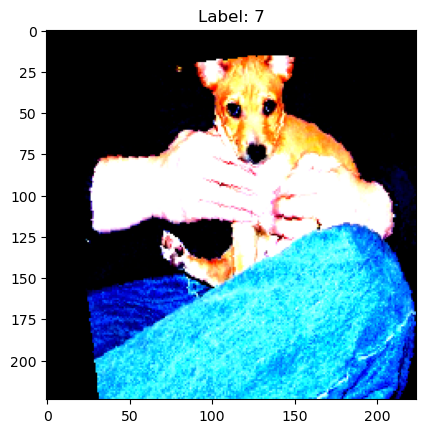

In [10]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [11]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [12]:
!pip install timm


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import timm

# timm 中的 xception 模型，使用預訓練權重
model = timm.create_model('xception', pretrained=True, num_classes=num_classes)


# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

/opt/conda/lib/python3.9/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [15]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 50
# 1. 計算 class weights（根據整體 dataset 分布）
from collections import Counter

label_counts = Counter(dataset.labels)
num_classes = 120
class_counts = [label_counts[i] for i in range(num_classes)]

# 權重：類別樣本越少，損失權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 定義損失函數與優化器
# 優化器與損失函數
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# 學習率調整器
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# 初始化 EarlyStopping 與最佳模型追蹤
early_stopping_patience = 5
no_improve_epochs = 0
best_val_loss = float("inf")
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    model.train()  # 訓練模式
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step(epoch)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 驗證階段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # 檢查是否為最佳模型，若是就儲存
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print("✅ 儲存最佳模型！")
    else:
        no_improve_epochs += 1
        print(f"⏸️ 連續 {no_improve_epochs} 次沒有改善")

    # EarlyStopping 檢查
    if no_improve_epochs >= early_stopping_patience:
        print(f"🛑 驗證損失已連續 {early_stopping_patience} 次未改善，提前停止訓練。")
        break

print("✅ 訓練結束，最佳模型已儲存為 best_model.pth")


Epoch 1/50, Loss: 2.0989, Accuracy: 56.80%


/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.9038, Validation Accuracy: 74.66%
✅ 儲存最佳模型！
Epoch 2/50, Loss: 0.7842, Accuracy: 77.84%
Validation Loss: 0.8831, Validation Accuracy: 74.85%
✅ 儲存最佳模型！
Epoch 3/50, Loss: 0.5712, Accuracy: 82.88%
Validation Loss: 0.8414, Validation Accuracy: 75.83%
✅ 儲存最佳模型！
Epoch 4/50, Loss: 0.4334, Accuracy: 87.17%
Validation Loss: 0.8081, Validation Accuracy: 76.52%
✅ 儲存最佳模型！
Epoch 5/50, Loss: 0.3381, Accuracy: 90.16%
Validation Loss: 0.7663, Validation Accuracy: 77.89%
✅ 儲存最佳模型！
Epoch 6/50, Loss: 0.2494, Accuracy: 92.96%
Validation Loss: 0.7719, Validation Accuracy: 78.13%
⏸️ 連續 1 次沒有改善
Epoch 7/50, Loss: 0.1820, Accuracy: 95.08%
Validation Loss: 0.7381, Validation Accuracy: 78.33%
✅ 儲存最佳模型！
Epoch 8/50, Loss: 0.1341, Accuracy: 96.60%
Validation Loss: 0.7139, Validation Accuracy: 80.58%
✅ 儲存最佳模型！
Epoch 9/50, Loss: 0.1290, Accuracy: 96.92%
Validation Loss: 0.6726, Validation Accuracy: 80.58%
✅ 儲存最佳模型！
Epoch 10/50, Loss: 0.1033, Accuracy: 97.51%
Validation Loss: 0.6948, Validation Accur

In [17]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [18]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 78.57%


In [19]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [20]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [21]:
# 使用 softmax 輸出機率
results = []

with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # shape: (batch_size, 120)

        for img_id, prob_vector in zip(image_ids, probs):
            row = {"id": img_id}
            for breed, prob in zip(all_breeds, prob_vector):
                row[breed] = prob
            results.append(row)

# 轉成 DataFrame 並輸出
df = pd.DataFrame(results)
df = df[["id"] + all_breeds]  # 確保順序符合要求
df.to_csv("submission55555.csv", index=False)
print("✅ submission4.csv 已成功輸出，格式符合 Kaggle 要求！")


✅ submission4.csv 已成功輸出，格式符合 Kaggle 要求！
